In [1]:
import pandas as pd
import numpy as np
import torch
from data_provider.data_factory import Data_Provider
import yaml, json
from utils.tools import dotdict

In [2]:
# load json
with open('checkpoints/03-11-0936_FITS_solar_day_ahead/args.json', 'r') as f:
    args = json.load(f)
args = dotdict(args)

In [83]:
# load yaml
with open('./data_configs/fullsolar_hetero.yaml') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)
data_config = dotdict(data_config)
args.data_config = data_config

args.scale = False

In [84]:
a=Data_Provider(args, buffer=(not args.disable_buffer))

[ info ] Successfully load the dynamic data from fast_general_weather_forecast_????.json


In [86]:
set = a.get_val('set')

Loading val datasets: 100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


In [88]:
set.keys()

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])

In [89]:
seta = set['314106']
len(seta)

8569

In [90]:
seta[2000]

(array([[0.0000e+00],
        [0.0000e+00],
        [4.3000e-02],
        [1.4500e-01],
        [1.1800e-01],
        [3.0700e-01],
        [2.8600e-01],
        [3.5400e-01],
        [1.1800e-01],
        [3.0000e-03],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.2000e-02],
        [4.5700e-01],
        [1.4480e+00],
        [1.6810e+00],
        [2.6970e+00],
        [2.3210e+00],
        [2.5470e+00],
        [2.7520e+00],
        [1.8700e+00],
        [2.1600e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0

In [9]:
seta[2000][3]

array([20210401080000, 20210401090000, 20210401100000, 20210401110000,
       20210401120000, 20210401130000, 20210401140000, 20210401150000,
       20210401160000, 20210401170000, 20210401180000, 20210401190000,
       20210401200000, 20210401210000, 20210401220000, 20210401230000,
       20210402000000, 20210402010000, 20210402020000, 20210402030000,
       20210402040000, 20210402050000, 20210402060000, 20210402070000])

## try with openai API

In [ ]:
# ts_x, ts_y, tm_x, tm_y, (dy_tm_x, general, channel, [dy_x]), (dy_tm_y, general, channel, [dy_y])

In [10]:
import openai

In [11]:
openai.base_url = 'http://localhost:8021/v1/'
openai.api_key = 'EMPTY'

In [94]:
system_prompt = "You are a professonal data analyst. You can do the forecasting by considering the historical reading time series along with weather condition and make the prediction for the next 24 hours. " + seta[2000][4][1] + "Please directly do the forecasting without any further external tools such as coding. You can consider the periodicity, trend, and seasonality of the data. Then consider the affect of weather condition to further refine your prediction. "


In [91]:
x_ts = seta[2000][0].squeeze().tolist()
x_timestamp = seta[2000][2].tolist()
x_table = [(x_timestamp[i], x_ts[i]) for i in range(len(x_ts))]

x_dy = seta[2000][4][-1]
x_dy_timestamp = seta[2000][4][0]
x_dy_table = [(x_dy_timestamp[i], x_dy[i]) for i in range(len(x_dy))]

channel_info = seta[2000][4][2]
channel_info

'The solar panel is located at Calgary Fire Hall Headquarters.'

In [92]:
y_ts = seta[2000][1].squeeze().tolist()
y_timestamp = seta[2000][3].tolist()

y_dy = seta[2000][5][-1]
y_dy_timestamp = seta[2000][5][0]
y_dy_table = [(y_dy_timestamp[i], y_dy[i]) for i in range(len(y_dy))]
y_dy_table

[('20210401000000',
  '{"daily":"It\'s going to be a chilly April day with a mix of passing clouds and broken clouds. Expect a temperature trend of warming up in the morning and cooling down in the evening. There might be a sudden shower in the late afternoon. Overall, it\'s a great day to enjoy the outdoors with a light jacket.","Early Morning":"Early morning will be quite chilly with a temperature around 2-3\\u00b0C. Expect passing clouds with a gentle breeze. It\'s a great time to get some fresh air and enjoy the morning.","Morning":"Morning will see a slight warming up with temperatures reaching around 10-12\\u00b0C. The sky will be partly sunny with a gentle breeze. It\'s a perfect time to get out and about.","Afternoon":"Afternoon will be quite windy with gusts reaching up to 50 km\\/h. Temperatures will be around 14-16\\u00b0C. Expect passing clouds with a chance of sudden showers. It\'s a good idea to carry an umbrella.","Evening":"Evening will see a cooling down with temperatu

In [93]:
user_prompt = f'''

We now have the data from {channel_info}. The historical data is as follows:

{x_table}

The historical weather condition is as follows:

{x_dy_table}

We now have the weather forecasting for the following days:

{y_dy_table}

Please make the prediction for the next 24 hours.

The timestamp for forecasting is as follows:

{y_timestamp}

Please format it in json format in [datastamp, value] pair, as below:

```json

[[<timestamp>, <predicted_value>],
 [<timestamp>, <predicted_value>],
 ...]

```
'''

In [95]:
messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt}
]

In [96]:
avaliable_models = openai.models.list()
avaliable_models = [model.id for model in avaliable_models.data]
avaliable_models

['Qwen/Qwen2.5-14B-Instruct',
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
 'meta-llama/Llama-3.1-8B-Instruct']

In [72]:
import re

In [73]:
def extract_result(result):
    pattern = r'```json(.*?)```'
    result = re.search(pattern, result, re.DOTALL)
    pred = json.loads(result.group(1))

    return pred

In [99]:
# do multi processing
import multiprocessing

def call_openai(model_id, messages):
    temp = 0.2
    if 'DeepSeek' in model_id:
        messages[1]['content']=messages[0]['content']+messages[1]['content']
        messages[0]['content']=''
        temp = 0.6
    response = openai.chat.completions.create(
        model=model_id,
        messages=messages,
        temperature=temp,
    )
    extracted = extract_result(response.choices[0].message.content)
    return extracted, response.choices[0].message.content, model_id
    # return response.choices[0].message.content

pool = multiprocessing.Pool(processes=4)
results = pool.starmap(call_openai, [(model_id, messages) for model_id in avaliable_models])

In [102]:
results

[([['20210401080000', 0.164],
   ['20210401090000', 1.504],
   ['20210401100000', 3.929],
   ['20210401110000', 6.343],
   ['20210401120000', 8.661],
   ['20210401130000', 13.408],
   ['20210401140000', 14.59],
   ['20210401150000', 14.38],
   ['20210401160000', 11.317],
   ['20210401170000', 8.285],
   ['20210401180000', 2.892],
   ['20210401190000', 3.385],
   ['20210401200000', 0.608],
   ['20210401210000', 0.0],
   ['20210401220000', 0.0],
   ['20210401230000', 0.0],
   ['20210402000000', 0.0],
   ['20210402010000', 0.0],
   ['20210402020000', 0.0],
   ['20210402030000', 0.0],
   ['20210402040000', 0.0],
   ['20210402050000', 0.0],
   ['20210402060000', 0.0],
   ['20210402070000', 0.0]],
  'To make the prediction for the next 24 hours, we need to consider the historical solar power generation data and the weather conditions. The historical data shows a clear pattern of solar generation peaking during the day and dropping to zero during the night. The weather conditions will also in

In [61]:
import matplotlib.pyplot as plt

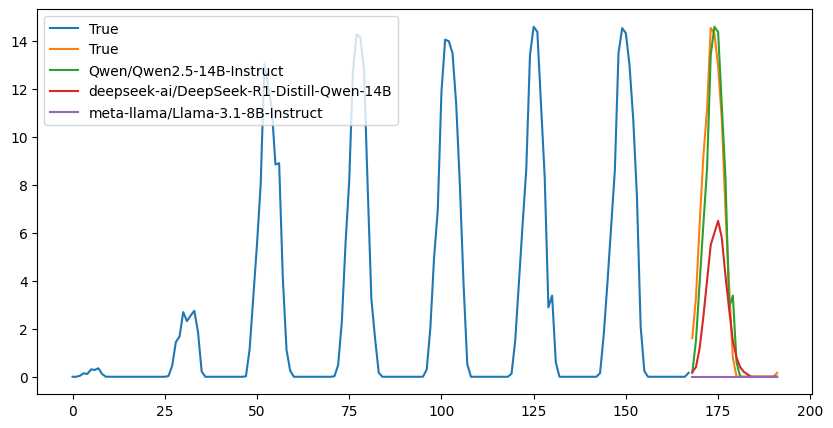

In [105]:
%matplotlib inline

plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(x_ts)), x_ts, label='True')

plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), y_ts, label='True')

for result in results:
    pred = result[0][:24]
    model_id = result[2]
    plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), [x[1] for x in pred], label=model_id)





plt.legend()

plt.show()


In [98]:
user_prompt

'\n\nWe now have the data from The solar panel is located at Calgary Fire Hall Headquarters.. The historical data is as follows:\n\n[(20210325080000, 0.0), (20210325090000, 0.0), (20210325100000, 0.043), (20210325110000, 0.145), (20210325120000, 0.118), (20210325130000, 0.307), (20210325140000, 0.286), (20210325150000, 0.354), (20210325160000, 0.118), (20210325170000, 0.003), (20210325180000, 0.0), (20210325190000, 0.0), (20210325200000, 0.0), (20210325210000, 0.0), (20210325220000, 0.0), (20210325230000, 0.0), (20210326000000, 0.0), (20210326010000, 0.0), (20210326020000, 0.0), (20210326030000, 0.0), (20210326040000, 0.0), (20210326050000, 0.0), (20210326060000, 0.0), (20210326070000, 0.0), (20210326080000, 0.0), (20210326090000, 0.0), (20210326100000, 0.032), (20210326110000, 0.457), (20210326120000, 1.448), (20210326130000, 1.681), (20210326140000, 2.697), (20210326150000, 2.321), (20210326160000, 2.547), (20210326170000, 2.752), (20210326180000, 1.87), (20210326190000, 0.216), (202